In [1]:
import SALib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from model import GeoVictoria

In [44]:
# We define our variables and bounds
problem = {
    'num_vars': 4,
    'names': ['stoch', 'alpha', 'beta', 'gamma'],
    'bounds': [[0.5, 1], [1.5, 2.5], [0.1, 0.3], [0.001, 0.005]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 5
max_steps = 10
distinct_samples = 3


def get_data(problem, replicates, max_steps, distinct_samples):
    # Set the outputs
    model_reporters = {"Population": lambda m: [a.population for a in m.space.agents]}

    data = {}

    for i, var in enumerate(problem['names']):
        # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
        
        # Keep in mind that wolf_gain_from_food should be integers. You will have to change
        # your code to acommodate for this or sample in such a way that you only get integers.
        # if var == 'wolf_gain_from_food':
        #     samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
        
        batch = BatchRunner(GeoVictoria, 
                            max_steps=max_steps,
                            iterations=replicates,
                            variable_parameters={var: samples},
                            model_reporters=model_reporters,
                            display_progress=True)
        
        batch.run_all()
        
        data[var] = batch.get_model_vars_dataframe()

def read_data(problem, convert=True):
    data = dict()
    for var in problem['names']:
        data[var] = pd.read_csv(f'Data/SA_data_{var}.csv')
        if convert:
            print(gini(data[var]['Population'].iloc[0]))
            data[var]['gini'] = [gini(np.array(data[var]['Population'].iloc[i])) for i in range(len(data[var]['Population']))]

    return data

def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

data = read_data(problem)

[4, 5, 9, 4, 3, 4, 21, 7, 1, 6, 6, 3, 6, 11, 9, 5, 9, 5, 14, 26, 27, 3, 5, 10, 11, 13, 6, 7, 18, 6, 6, 5, 15, 0, 34, 2, 2, 12, 5, 10, 9, 9, 12, 9, 1, 4, 6, 16, 53, 43, 14, 4, 26, 12, 16, 2, 6, 4, 3, 5, 3, 9, 5, 9, 9, 11, 37, 1, 16, 51, 8, 6, 5, 5, 10, 16, 19, 12, 5, 25, 2, 18, 6, 3, 2, 7, 13, 12, 7, 2, 1, 26, 32, 9, 1, 8, 10, 1, 2, 7, 4, 11, 3, 3, 22, 39, 12, 1, 8, 3, 3, 2, 23, 2, 40, 3, 46, 13, 6, 8, 8, 22, 10, 4, 6, 3, 6, 4, 2, 1, 3, 4, 5, 9, 15, 13, 10, 13, 2, 14, 8, 24, 3, 2, 5, 8, 17, 8, 14, 11, 16, 2, 21, 8, 8, 4, 10, 14, 12, 21, 6, 3, 11, 13, 9, 4, 28, 4, 13, 15, 4, 24, 25, 16, 15, 2, 47, 24, 9, 3, 25, 5, 5, 7, 9, 25, 6, 12, 18, 10, 6, 10, 8, 4, 11, 3, 14, 12, 4, 39, 6, 9, 7, 8, 8, 1, 14, 16, 10, 9, 5, 3, 4, 4, 5, 6, 9, 10, 7, 7, 12, 11, 3, 1, 9, 14, 10, 15, 8, 2, 7, 8, 30, 57, 11, 5, 3, 11, 6, 5, 12, 2, 7, 20, 4, 28, 10, 11, 10, 7, 18, 5, 6, 4, 14, 7, 9, 8, 42, 4, 3, 9, 5, 22, 19, 2, 2, 3, 11, 17, 8, 10, 11, 0, 10, 17, 10, 29, 2, 5, 43, 11, 1, 22, 2, 3, 15, 25, 6, 19, 4, 10, 12

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [31]:
data['stoch']['Population']

0     [4, 5, 9, 4, 3, 4, 21, 7, 1, 6, 6, 3, 6, 11, 9...
1     [0, 5, 27, 6, 21, 4, 2, 8, 4, 13, 4, 26, 31, 1...
2     [4, 7, 7, 14, 8, 9, 9, 9, 12, 5, 6, 6, 12, 15,...
3     [17, 2, 18, 16, 9, 24, 2, 5, 19, 14, 3, 3, 8, ...
4     [7, 3, 8, 6, 6, 2, 10, 12, 7, 31, 11, 25, 8, 1...
5     [1, 8, 6, 26, 9, 5, 7, 12, 5, 11, 13, 3, 14, 9...
6     [11, 5, 23, 6, 9, 8, 4, 14, 6, 9, 6, 3, 8, 12,...
7     [18, 9, 2, 8, 8, 6, 9, 9, 3, 34, 7, 2, 9, 10, ...
8     [12, 9, 20, 8, 3, 9, 14, 9, 6, 7, 4, 15, 2, 11...
9     [7, 14, 5, 17, 9, 3, 11, 3, 14, 1, 3, 42, 1, 7...
10    [9, 5, 5, 2, 5, 10, 2, 37, 5, 8, 5, 4, 2, 4, 2...
11    [12, 18, 10, 4, 1, 14, 5, 21, 7, 0, 8, 23, 4, ...
12    [8, 2, 8, 14, 13, 9, 5, 6, 4, 14, 10, 14, 2, 3...
13    [9, 2, 4, 15, 7, 13, 11, 5, 4, 13, 7, 10, 1, 7...
14    [11, 12, 0, 3, 5, 11, 16, 14, 4, 18, 19, 3, 3,...
Name: Population, dtype: object

In [34]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    # print(df)
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param, problem):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(3, figsize=(7, 10))
    
    for i, var in enumerate(problem['names']):
        print(i, var, df[var])
        plot_param_var_conf(axs[i], df, var, param, i)

0 stoch     Unnamed: 0  stoch  Run                                         Population
0            0   0.50    0  [4, 5, 9, 4, 3, 4, 21, 7, 1, 6, 6, 3, 6, 11, 9...
1            1   0.50    1  [0, 5, 27, 6, 21, 4, 2, 8, 4, 13, 4, 26, 31, 1...
2            2   0.50    2  [4, 7, 7, 14, 8, 9, 9, 9, 12, 5, 6, 6, 12, 15,...
3            3   0.50    3  [17, 2, 18, 16, 9, 24, 2, 5, 19, 14, 3, 3, 8, ...
4            4   0.50    4  [7, 3, 8, 6, 6, 2, 10, 12, 7, 31, 11, 25, 8, 1...
5            5   0.75    5  [1, 8, 6, 26, 9, 5, 7, 12, 5, 11, 13, 3, 14, 9...
6            6   0.75    6  [11, 5, 23, 6, 9, 8, 4, 14, 6, 9, 6, 3, 8, 12,...
7            7   0.75    7  [18, 9, 2, 8, 8, 6, 9, 9, 3, 34, 7, 2, 9, 10, ...
8            8   0.75    8  [12, 9, 20, 8, 3, 9, 14, 9, 6, 7, 4, 15, 2, 11...
9            9   0.75    9  [7, 14, 5, 17, 9, 3, 11, 3, 14, 1, 3, 42, 1, 7...
10          10   1.00   10  [9, 5, 5, 2, 5, 10, 2, 37, 5, 8, 5, 4, 2, 4, 2...
11          11   1.00   11  [12, 18, 10, 4, 1, 14, 5, 21

AttributeError: 'dict' object has no attribute 'groupby'

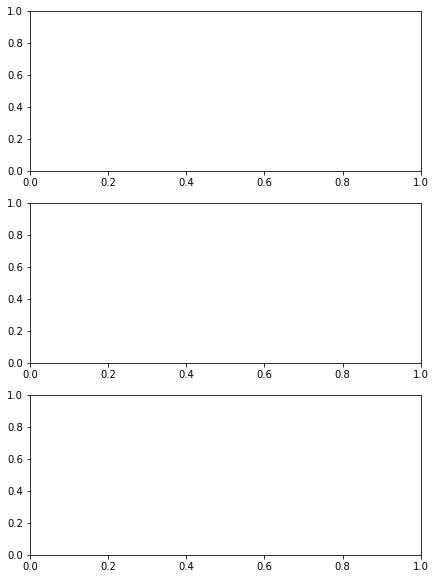

In [35]:
plot_all_vars(data, 'Population', problem)
plt.show()